In [173]:
# detected anomalies in cpu usage of AWS EC2 instance
# used MAD, Isolated Forest, and Local Outlier Factor models to detect anomalies

# data: https://github.com/numenta/NAB/blob/master/data/realAWSCloudwatch/ec2_cpu_utilization_24ae8d.csv

In [174]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [175]:
df = pd.read_csv('cpu.csv')

In [176]:
df.head()

,timestamp,value
0,2014-02-14 14:30:00,0.132
1,2014-02-14 14:35:00,0.134
2,2014-02-14 14:40:00,0.134
3,2014-02-14 14:45:00,0.134
4,2014-02-14 14:50:00,0.134


In [177]:
# convert timestamp column to timestamp type
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [178]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4032 entries, 0 to 4031
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  4032 non-null   datetime64[ns]
 1   value      4032 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 63.1 KB


In [179]:
df['found_anomaly'] = 1
#  1 - normal
# -1 - outlier

In [180]:
# label anomaly feature for outlier dates
anomalies = [
    "2014-02-26 22:05:00",
    "2014-02-27 17:15:00"
]

for day in anomalies:
  df.loc[df['timestamp'] == day, 'found_anomaly'] = -1

In [181]:
# normalize data values
values_to_normalize = df['value'].values.reshape(-1, 1)

normalize = MinMaxScaler()
normalized_values = normalize.fit_transform(values_to_normalize)
df['value'] = normalized_values.flatten()

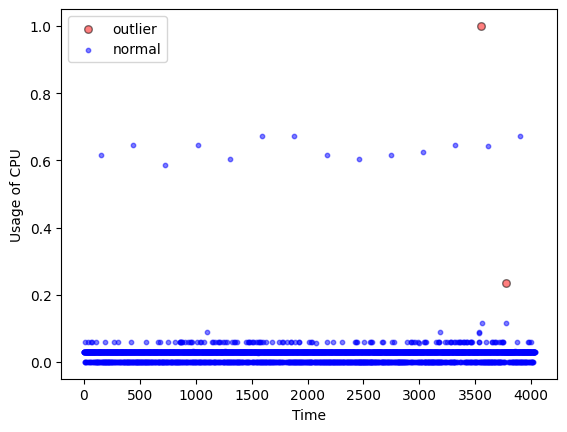

In [182]:
outlier = df.loc[df['found_anomaly'] == -1]
normal = df.loc[df['found_anomaly'] == 1]

plt.scatter(outlier.index, outlier['value'], color='red', edgecolors='black', s=30, alpha=0.5, label='outlier')
plt.scatter(normal.index, normal['value'], color='blue', s=10, alpha=0.5, label='normal')
plt.xlabel('Time')
plt.ylabel('Usage of CPU')
plt.legend()


In [183]:
'''
MAD
- when data normally distributed, tail points are outliers
- use robust z score to measure distance from median
'''

from scipy.stats import median_abs_deviation

MAD = median_abs_deviation(df['value'])
median = np.median(df['value'])
print(MAD, median)

0.0008779631255487266 0.029850746268656716


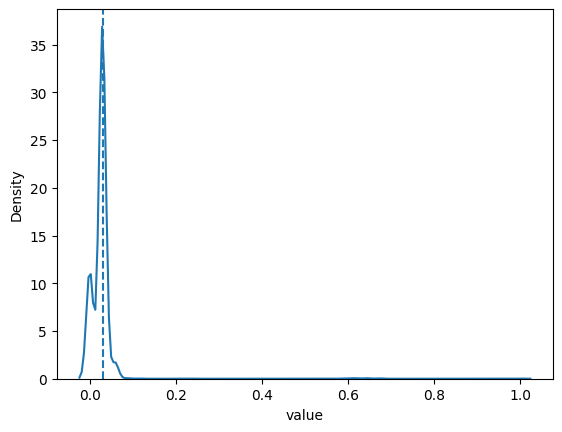

In [184]:
import seaborn as sns
sns.kdeplot(df['value'])
plt.axvline(median, 0, 1, ls='--')

In [185]:
df['z-score'] = 0.6745 * (df['value'] - median) / MAD
df.head()

,timestamp,value,found_anomaly,z-score
0,2014-02-14 14:30:00,0.028973,1,-0.6745
1,2014-02-14 14:35:00,0.029851,1,0.0000
2,2014-02-14 14:40:00,0.029851,1,0.0000
3,2014-02-14 14:45:00,0.029851,1,0.0000
4,2014-02-14 14:50:00,0.029851,1,0.0000


In [186]:
df['mad_prediction'] = 1
df.loc[df['z-score'] > 3.5, 'mad_prediction'] = -1
df.loc[df['z-score'] <= 3.5, 'mad_prediction'] = 1

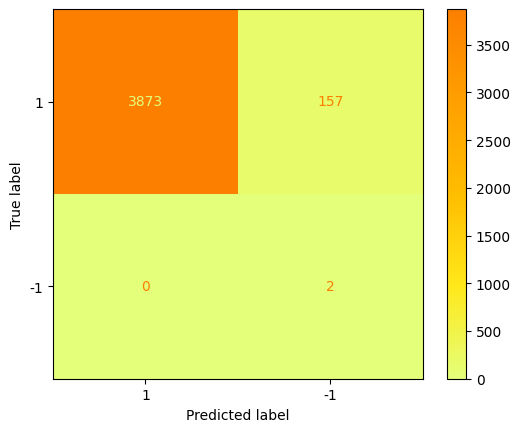

In [187]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

res = confusion_matrix(df['found_anomaly'], df['mad_prediction'], labels=[1, -1])
display_res = ConfusionMatrixDisplay(res, display_labels=[1, -1])

display_res.plot(cmap='Wistia')
# able to predict all true outliers but also false positives

In [188]:
'''
Isolation Forest
- partition data to isolate points
- least required partitons = greatest outlier
'''

from sklearn.ensemble import IsolationForest
train, test = df[:3550], df[3550:]

In [189]:
contamination = 1/len(train)

forest = IsolationForest(contamination=contamination, random_state=54)
x_train = train['value'].values.reshape(-1, 1)
forest.fit(x_train)

IsolationForest(contamination=0.00028169014084507044, random_state=54)

In [190]:
predict = forest.predict(test['value'].values.reshape(-1, 1))

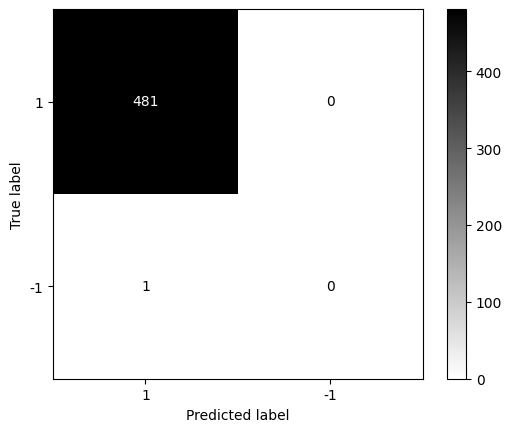

In [191]:
res = confusion_matrix(test['found_anomaly'], predict, labels=[1, -1])
display_res = ConfusionMatrixDisplay(res, display_labels=[1, -1])

display_res.plot(cmap='binary')
# model unable to find outliers

In [192]:
'''
LOF = local outlier factor
- unsupervised detection by density comparison
- compare local densities, small density = outlier
'''

from sklearn.neighbors import LocalOutlierFactor

LOF = LocalOutlierFactor(contamination=contamination, novelty=True)
LOF.fit(x_train)

LocalOutlierFactor(contamination=0.00028169014084507044, novelty=True)

In [193]:
lof_predict = LOF.predict(test['value'].values.reshape(-1, 1))

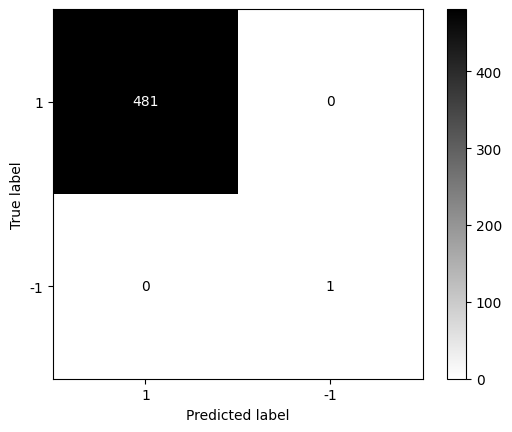

In [194]:
res = confusion_matrix(test['found_anomaly'], lof_predict, labels=[1, -1])
display_res = ConfusionMatrixDisplay(res, display_labels=[1, -1])

display_res.plot(cmap='binary')
# perfect prediction